# Computer Vision - AV-HuBERT Downstream Task Research

## Install Modules
This section installs necessary python packages for the other sections. Run it first.

In [1]:
!git clone https://github.com/facebookresearch/av_hubert.git

!cd avhubert
!git submodule init
!git submodule update
!pip install scipy
!pip install sentencepiece
!pip install python_speech_features
!pip install scikit-video

%cd fairseq
%pip install ./

Cloning into 'av_hubert'...
remote: Enumerating objects: 146, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 146 (delta 17), reused 25 (delta 12), pack-reused 111
Receiving objects: 100% (146/146), 4.65 MiB | 2.11 MiB/s, done.
Resolving deltas: 100% (63/63), done.
/bin/bash: line 0: cd: avhubert: No such file or directory
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
[Errno 2] No such file or directory: 'fairseq'
/media/joe/DCC4B54EC4B52C20/Users/win8t/OneDrive/Desktop/projects/uni-all/comp-vis-avhubert
ERROR: Directory './' is not installable. Neither 'setup.py' nor 'pyproject.toml' found.
Note: you may need to restart the kernel to use updated packages.


## Preprocess Dataset for AV-HuBERT

1. Install necessary tools for preprocessing

In [2]:
# !mkdir -p ./data/misc/
# !wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2 -O ./data/misc/shape_predictor_68_face_landmarks.dat.bz2
# !bzip2 -d ./data/misc/shape_predictor_68_face_landmarks.dat.bz2
# !wget --content-disposition https://github.com/mpc001/Lipreading_using_Temporal_Convolutional_Networks/raw/master/preprocessing/20words_mean_face.npy -O ./data/misc/20words_mean_face.npy

2. Download a video from online

In [3]:
# !wget --content-disposition https://dl.fbaipublicfiles.com/avhubert/demo/avhubert_demo_video_8s.mp4 -O ./data/clip.mp4

3. Extract mouth ROI.

In [1]:
%cd ./av_hubert/avhubert/
# %cd ./avhubert

import dlib, cv2, os
import numpy as np
import skvideo
import skvideo.io
from tqdm import tqdm
from preparation.align_mouth import landmarks_interpolate, crop_patch, write_video_ffmpeg
from IPython.display import HTML
from base64 import b64encode

def play_video(video_path, width=200):
  mp4 = open(video_path,'rb').read()
  data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
  return HTML(f"""
  <video width={width} controls>
        <source src="{data_url}" type="video/mp4">
  </video>
  """)

def detect_landmark(image, detector, predictor):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    rects = detector(gray, 1)
    coords = None
    for (_, rect) in enumerate(rects):
        shape = predictor(gray, rect)
        coords = np.zeros((68, 2), dtype=np.int32)
        for i in range(0, 68):
            coords[i] = (shape.part(i).x, shape.part(i).y)
    return coords

def preprocess_video(input_video_path, output_video_path, face_predictor_path, mean_face_path):
  detector = dlib.get_frontal_face_detector()
  predictor = dlib.shape_predictor(face_predictor_path)
  STD_SIZE = (256, 256)
  mean_face_landmarks = np.load(mean_face_path)
  stablePntsIDs = [33, 36, 39, 42, 45]
  videogen = skvideo.io.vread(input_video_path)
  frames = np.array([frame for frame in videogen])
  landmarks = []
  for frame in tqdm(frames):
      landmark = detect_landmark(frame, detector, predictor)
      landmarks.append(landmark)
  preprocessed_landmarks = landmarks_interpolate(landmarks)
  rois = crop_patch(input_video_path, preprocessed_landmarks, mean_face_landmarks, stablePntsIDs, STD_SIZE, 
                        window_margin=12, start_idx=48, stop_idx=68, crop_height=96, crop_width=96)
  write_video_ffmpeg(rois, output_video_path, "/usr/bin/ffmpeg")
  return

/media/joe/DCC4B54EC4B52C20/Users/win8t/OneDrive/Desktop/projects/uni-all/comp-vis-avhubert/av_hubert/avhubert


In [2]:
%pwd

'/media/joe/DCC4B54EC4B52C20/Users/win8t/OneDrive/Desktop/projects/uni-all/comp-vis-avhubert/av_hubert/avhubert'

In [6]:
%cd ..

/media/joe/DCC4B54EC4B52C20/Users/win8t/OneDrive/Desktop/projects/uni-all/comp-vis-avhubert


In [7]:
play_video('./clips/clip_1.mp4', width=300)

In [9]:
for clip_idx in range(6):
    clip_idx += 1
    data_dir            = "clips"
    face_predictor_path = f"./misc/shape_predictor_68_face_landmarks.dat"
    mean_face_path      = f"./misc/20words_mean_face.npy"
    origin_clip_path    = f"./{data_dir}/clip_{clip_idx}.mp4"
    mouth_roi_path      = f"./{data_dir}/clip_{clip_idx}_roi.mp4"
    preprocess_video(origin_clip_path, mouth_roi_path, face_predictor_path, mean_face_path)
    play_video(mouth_roi_path)

100%|██████████| 34/34 [00:02<00:00, 14.51it/s]


### AV-HuBERT (Inference for Features)

In [10]:
%pwd

'/media/joe/DCC4B54EC4B52C20/Users/win8t/OneDrive/Desktop/projects/uni-all/comp-vis-avhubert'

In [14]:
import os
# %cd ./avhubert
import cv2
import tempfile
from argparse import Namespace
import fairseq
from fairseq import checkpoint_utils, options, tasks, utils
from fairseq.dataclass.configs import GenerationConfig
from IPython.display import HTML

# os.environ["CUDA_VISIBLE_DEVICES"] = "0"

def predict(video_path, ckpt_path, user_dir):
  num_frames = int(cv2.VideoCapture(video_path).get(cv2.CAP_PROP_FRAME_COUNT))
  data_dir = tempfile.mkdtemp()
  tsv_cont = ["/\n", f"test-0\t{video_path}\t{None}\t{num_frames}\t{int(16_000*num_frames/25)}\n"]
  label_cont = ["DUMMY\n"]
  with open(f"{data_dir}/test.tsv", "w") as fo:
    fo.write("".join(tsv_cont))
  with open(f"{data_dir}/test.wrd", "w") as fo:
    fo.write("".join(label_cont))
  fairseq.utils.import_user_module(Namespace(user_dir=user_dir))
  modalities = ["video"]
  gen_subset = "test"
  gen_cfg = GenerationConfig(beam=20)
  models, saved_cfg, task = fairseq.checkpoint_utils.load_model_ensemble_and_task([ckpt_path])
  models = [model.eval().cuda() for model in models]
  saved_cfg.task.modalities = modalities
  saved_cfg.task.data = data_dir
  saved_cfg.task.label_dir = data_dir
  task = tasks.setup_task(saved_cfg.task)
  task.load_dataset(gen_subset, task_cfg=saved_cfg.task)
  generator = task.build_generator(models, gen_cfg)

  def decode_fn(x):
      dictionary = task.target_dictionary
      symbols_ignore = generator.symbols_to_strip_from_output
      symbols_ignore.add(dictionary.pad())
      return task.datasets[gen_subset].label_processors[0].decode(x, symbols_ignore)

  itr = task.get_batch_iterator(dataset=task.dataset(gen_subset)).next_epoch_itr(shuffle=False)
  sample = next(itr)
  sample = utils.move_to_cuda(sample)
  hypos = task.inference_step(generator, models, sample)
  ref = decode_fn(sample['target'][0].int().cpu())
  hypo = hypos[0][0]['tokens'].int().cpu()
  hypo = decode_fn(hypo)
  return hypo

def pred(data_dir, clip_idx):
  # Linux
  # mouth_roi_path, ckpt_path = "./data/roi.mp4", "./data/base_vox_433h.pt"
  # mouth_roi_path = "C:/Users/win8t/OneDrive/Desktop/projects/uni-all/comp-vis-avhubert/data/roi.mp4"
  # ckpt_path      = "C:/Users/win8t/OneDrive/Desktop/projects/uni-all/comp-vis-avhubert/base_vox_433h.pt"
  #mouth_roi_path = "./data/roi.mp4"
  #ckpt_path = "./data/.mp4"
  user_dir       = "/media/joe/DCC4B54EC4B52C20//Users/win8t/OneDrive/Desktop/projects/uni-all/comp-vis-avhubert/av_hubert/avhubert"
  # mouth_roi_path, ckpt_path = "./data/roi.mp4", "./data/base_vox_433h.pt"
  mouth_roi_path = f"/media/joe/DCC4B54EC4B52C20//Users/win8t/OneDrive/Desktop/projects/uni-all/comp-vis-avhubert/{data_dir}/clip_{clip_idx}_roi.mp4"
  ckpt_path      = f"/media/joe/DCC4B54EC4B52C20/Users/win8t/OneDrive/Desktop/projects/uni-all/comp-vis-avhubert/base_vox_433h.pt"
  # mouth_roi_path = f"./{data_dir}/roi.mp4"
  #ckpt_path = "./data/.mp4"
  #user_dir       = "C:/Users/win8t/OneDrive/Desktop/projects/uni-all/av_hubert/avhubert"
  hypo = predict(mouth_roi_path, ckpt_path, user_dir)
  return hypo

hypo_s = []

for clip_idx in range(6):
  clip_idx += 1
  hypo = pred("clips", clip_idx)
  hypo_s.append(hypo)
  
HTML(f"""
  <h3>
    Prediction - {hypo}
  </h3>
  """)

/home/joe/.local/lib/python3.8/site-packages/fairseq/search.py:140: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  beams_buf = indices_buf // vocab_size
/media/joe/DCC4B54EC4B52C20/Users/win8t/OneDrive/Desktop/projects/uni-all/comp-vis-avhubert/av_hubert/avhubert/sequence_generator.py:674: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  

In [20]:
HTML(f"""
  <h3>
    Prediction - {hypo_s[5]}
  </h3>
  """)

### Extract Visual Features

Shape of for visual features is [frames, 768], where 768 is the output of the AV-HuBERT Base Transformer Encoder module for each frame.

In [25]:
%cd /media/joe/DCC4B54EC4B52C20/Users/win8t/OneDrive/Desktop/projects/uni-all/comp-vis-avhubert/av_hubert/avhubert
import cv2
import tempfile
import torch
import utils as avhubert_utils
from argparse import Namespace
import fairseq
from fairseq import checkpoint_utils, options, tasks, utils
from IPython.display import HTML

def extract_visual_feature(video_path, ckpt_path, user_dir, is_finetune_ckpt=False):
  utils.import_user_module(Namespace(user_dir=user_dir))
  models, saved_cfg, task = checkpoint_utils.load_model_ensemble_and_task([ckpt_path])
  transform = avhubert_utils.Compose([
      avhubert_utils.Normalize(0.0, 255.0),
      avhubert_utils.CenterCrop((task.cfg.image_crop_size, task.cfg.image_crop_size)),
      avhubert_utils.Normalize(task.cfg.image_mean, task.cfg.image_std)])
  frames = avhubert_utils.load_video(video_path)
  print(f"Load video {video_path}: shape {frames.shape}")
  frames = transform(frames)
  print(f"Center crop video to: {frames.shape}")
  frames = torch.FloatTensor(frames).unsqueeze(dim=0).unsqueeze(dim=0).cuda()
  model = models[0]
  if hasattr(models[0], 'decoder'):
    print(f"Checkpoint: fine-tuned")
    model = models[0].encoder.w2v_model
  else:
    print(f"Checkpoint: pre-trained w/o fine-tuning")
  model.cuda()
  model.eval()
  with torch.no_grad():
    # Specify output_layer if you want to extract feature of an intermediate layer
    feature, _ = model.extract_finetune(source={'video': frames, 'audio': None}, padding_mask=None, output_layer=None)
    print(f"Video feature shape: {feature.shape}")
    feature = feature.squeeze(dim=0)
  print(f"Video feature shape: {feature.shape}")
  return feature

def get_all_features(clip_dir):
  features = []
  for clip_idx in range(6):
    clip_idx += 1
    mouth_roi_path = f"/media/joe/DCC4B54EC4B52C20/Users/win8t/OneDrive/Desktop/projects/uni-all/comp-vis-avhubert/{clip_dir}/clip_{clip_idx}_roi.mp4"
    ckpt_path      = "/media/joe/DCC4B54EC4B52C20/Users/win8t/OneDrive/Desktop/projects/uni-all/comp-vis-avhubert/base_vox_433h.pt"
    user_dir       = "/media/joe/DCC4B54EC4B52C20/Users/win8t/OneDrive/Desktop/projects/uni-all/comp-vis-avhubert/av_hubert"
    feature = extract_visual_feature(mouth_roi_path, ckpt_path, user_dir)
    features.append(feature)
  return features

features = get_all_features("clips")

/media/joe/DCC4B54EC4B52C20/Users/win8t/OneDrive/Desktop/projects/uni-all/comp-vis-avhubert/av_hubert/avhubert
Load video /media/joe/DCC4B54EC4B52C20/Users/win8t/OneDrive/Desktop/projects/uni-all/comp-vis-avhubert/clips/clip_1_roi.mp4: shape (240, 96, 96)
Center crop video to: (240, 88, 88)
Checkpoint: fine-tuned
Video feature shape: torch.Size([1, 240, 768])
Video feature shape: torch.Size([240, 768])
Load video /media/joe/DCC4B54EC4B52C20/Users/win8t/OneDrive/Desktop/projects/uni-all/comp-vis-avhubert/clips/clip_2_roi.mp4: shape (240, 96, 96)
Center crop video to: (240, 88, 88)
Checkpoint: fine-tuned
Video feature shape: torch.Size([1, 240, 768])
Video feature shape: torch.Size([240, 768])
Load video /media/joe/DCC4B54EC4B52C20/Users/win8t/OneDrive/Desktop/projects/uni-all/comp-vis-avhubert/clips/clip_3_roi.mp4: shape (240, 96, 96)
Center crop video to: (240, 88, 88)
Checkpoint: fine-tuned
Video feature shape: torch.Size([1, 240, 768])
Video feature shape: torch.Size([240, 768])
Load

#### Save Visual Features

In [27]:
%cd ../..

/media/joe/DCC4B54EC4B52C20/Users/win8t/OneDrive/Desktop/projects/uni-all/comp-vis-avhubert


In [28]:
%pwd

'/media/joe/DCC4B54EC4B52C20/Users/win8t/OneDrive/Desktop/projects/uni-all/comp-vis-avhubert'

In [26]:
features

[tensor([[-0.2028,  0.0122, -0.1656,  ..., -0.1434,  0.1187, -0.0526],
         [-0.1113, -0.2583,  0.2254,  ..., -0.5630,  0.2017, -0.4456],
         [-0.0200, -0.0558, -0.1099,  ..., -0.4544,  0.2002, -0.3556],
         ...,
         [ 0.1730,  0.1199, -0.0412,  ...,  0.5772,  0.3173, -0.0155],
         [ 0.1231,  0.2250,  0.1191,  ...,  0.2909,  0.0902, -0.0223],
         [ 0.2771,  0.1664,  0.2100,  ..., -0.3662,  0.2054, -0.0126]],
        device='cuda:0'),
 tensor([[-0.1943, -0.0393, -0.2321,  ...,  0.0082,  0.0698, -0.0251],
         [ 0.1264,  0.1262, -0.1441,  ..., -0.1462,  0.0152, -0.0380],
         [ 0.0492, -0.0618, -0.0691,  ...,  0.1221,  0.2983,  0.1724],
         ...,
         [ 0.2109,  0.6022, -0.0466,  ..., -0.2430, -0.2144, -0.1056],
         [ 0.0165,  0.3422,  0.1337,  ..., -0.3655, -0.2371, -0.1322],
         [-0.2328,  0.2515, -0.0092,  ..., -0.1974,  0.1634,  0.0466]],
        device='cuda:0'),
 tensor([[-0.0283,  0.0534, -0.1854,  ..., -0.0029,  0.0399, -0.10

In [27]:
features = torch.cat(tuple(features), dim=0)

In [28]:
features.shape

torch.Size([1234, 768])

In [31]:
%cd ../..

/media/joe/DCC4B54EC4B52C20/Users/win8t/OneDrive/Desktop/projects/uni-all/comp-vis-avhubert


In [32]:
torch.save(features, "./dataset/wsDmwoOrpR8/The False Appeal of Communism.pt")

## Dataset

In [1]:
def group_adjacent_duplicates(lst):
    result = []
    for item in lst:
        if len(result) == 0 or item != result[-1]:
            result.append(item)
    return result

### Dataset Loader

In [2]:
import torch

import numpy as np
import json
# import stable_whisper
import ffmpeg

import torchlm
from torchlm.tools import faceboxesv2
from torchlm.models import pipnet

from torch.utils.data import Dataset
from typing import TypedDict, List
from cv2 import Mat

# from ultralytics.yolo.data.dataloaders.stream_loaders import LoadImages

from lib import *


class LipSpeechMedia(TypedDict):
    """Class definition for single dataset item."""
    title:         str
    audio_raw:     np.ndarray
    audio_feats:   np.ndarray
    frames_raw:    np.ndarray
    frames_lm:     np.ndarray
    frames_bboxes: np.ndarray
    phonemes:      np.ndarray
    av_hubert:     np.ndarray


class LipSpeechDataset(Dataset):
    """Lip-to-speech Dataset."""
    def __init__(self,
                 metadata: str,
                 dataset_dir: Path,
                 phoneme_dir: Path,
                 phoneme_dict_path: Path = Path("./phoneme_dict.txt"),
                 whisper_model: str = "base",
                 device: str = "cpu") -> Dataset:
        """Load the dataset using the metadata *.json file."""
        with open(metadata) as f:
            obj   = json.loads(f.read())
            train = obj["train"]
            self.data = train
        self.dataset_dir   = Path(dataset_dir)

        """
        # OpenAI Whisper and Facial Landmark Model
        self.whisper_model = stable_whisper.load_model(whisper_model)
        torchlm.runtime.bind(faceboxesv2(device=device))
        torchlm.runtime.bind(
        pipnet(backbone="resnet18", pretrained=True,  
                num_nb=10, num_lms=98, net_stride=32, input_size=256,
                meanface_type="wflw", map_location=device, checkpoint=None))
        """

        
        # Phonemes
        phoneme_dict = load_phoneme_dict(phoneme_dict_path)
        phoneme_dict = [phone.lower() for phone in phoneme_dict]
        phoneme_dict[0] = "sil"
        for sil_tok in ['sp', 'spn']: # silence tokens
            if sil_tok in phoneme_dict:
                phoneme_dict.remove(sil_tok)
        for i in range(len(phoneme_dict)):
            if phoneme_dict[i][-1] in string.digits:
                phoneme_dict[i] = phoneme_dict[i][:-1]
        phoneme_dict = list(dict.fromkeys(phoneme_dict))
        self.phoneme_dict = phoneme_dict

        self.phoneme_dir  = phoneme_dir
        

    def __len__(self) -> int:
        """Return the number of media files in the dataset."""
        return len(self.data)
    
    def __getitem__(self, i) -> LipSpeechMedia:
        """Get the `n`th item in the dataset."""

        # Get media details
        media  = self.data[i]
        title  = media["title"]
        url    = media["url"]
        vid_id = extract_video_id(url)

        # Check if it has been downloaded
        vid_fname  = f"{vid_id}"
        vid_exists = check_existing(vid_fname, self.dataset_dir)
        vid_dir    = Path(self.dataset_dir) / vid_fname
        vid_path   = str(vid_dir / f"{title}.mp4")
        aud_path   = str(vid_dir / f"{title}.mp3")
        srt_path   = str(vid_dir / f"{title}.srt")
        raw_path   = str(vid_dir / f"{title}.json")
        grd_path   = str(vid_dir / f"{title}.TextGrid")
        lm_path    = str(vid_dir / f"{title}.pkl")
        av_path    = str(vid_dir / f"{title}.pt")
        if not vid_exists:
            youtube_download(url, vid_dir)

        """
        # Get captions using Whisper, if not existing
        if not os.path.exists(raw_path):
            result = self.whisper_model.transcribe(vid_path)
            result.to_srt_vtt(srt_path)
            result.save_as_json(raw_path)
        """

        # Extract MP3 from MP4 for audio features
        print("aud_path:", aud_path)
        if not os.path.exists(aud_path):
            input_stream  = ffmpeg.input(vid_path)
            audio_stream  = input_stream.audio
            output_stream = ffmpeg.output(audio_stream, aud_path)
            ffmpeg.run(output_stream)

        # Load audio
        audio_raw   = load_audio(aud_path)
        audio_feats = get_audio_feats(
            audio_raw,
            hop_length=667,
            win_length=1_024,
            filter_length=1_024) # Match Video

        # Load video frames
        """
        images = LoadImages(
            vid_path,
            imgsz=640,
            stride=1,
            vid_stride=1).__iter__()
        """

        """
        # Get Facial Landmarks and BBoxes from Frames
        frames = []
        bboxes = []
        lm_s   = []
        while True:
            try:
                _, _, im0, _, _ = next(images)
                landmarks, bboxe_s = torchlm.runtime.forward(im0)
                frames.append(im0)
                bboxes.append(bboxe_s)
                lm_s.append(landmarks)
            except StopIteration:
                break
        frames = np.stack(frames, axis=0)
        lm_s   = np.concatenate(lm_s, axis=0)
        bboxes =  np.concatenate(bboxes, axis=0)
        """

        """
        # Get Phonemes for Audio
        punctuations = string.punctuation
        translator = str.maketrans('', '', punctuations)
        w_words, w_starts, w_ends = [], [], []
        with open(raw_path) as f:
            raw_srt  = json.loads(f.read())
            segments = raw_srt["segments"]
            for seg in segments:
                words = seg["words"]
                for word in words:
                    # Normalise word
                    w_word  = word["word"].strip()
                    w_word  = w_word.strip()
                    w_word  = w_word.translate(translator)
                    w_word  = w_word.lower()

                    w_start = word["start"]
                    w_end   = word["end"]


                    if w_start == w_end:
                        w_start -= 0.01

                    w_words.append(w_word)
                    w_starts.append(w_start)
                    w_ends.append(w_end)
        word_alignments = pd.DataFrame({
            "word": w_words,
            "start": w_starts,
            "end": w_ends})
        textgrid = gen_textgrid(word_alignments)
        with open(grd_path, "w") as f:
            f.write(textgrid)
        """

        # Load Phonemes for Audio
        phonemes = load_phonemes(
            grd_path,
            audio_feats,
            self.phoneme_dict,
            temporal_scale=24)
        
        # Load AV-HuBERT Features
        av_hubert = torch.load(av_path)

        # Data
        out = {
            "title":         media["title"],
            "audio_raw":     audio_raw,
            "audio_feats":   audio_feats,
            #'"frames_raw":    frames,
            #"frames_lm":     lm_s,
            #"frames_bboxes": bboxes,
            "phonemes":      phonemes,
            "av_hubert":     av_hubert
        }

        return out

/usr/lib/python3/dist-packages/paramiko/transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


### Dataset Temporal Alignment (Check)

In [337]:
%pwd

'C:\\Users\\win8t\\OneDrive\\Desktop\\projects\\uni-all\\comp-vis-avhubert'

In [338]:
%cd ../..

C:\Users\win8t\OneDrive\Desktop\projects


In [339]:
%cd "C:\Users\win8t\OneDrive\Desktop\projects\uni-all\comp-vis-avhubert"

C:\Users\win8t\OneDrive\Desktop\projects\uni-all\comp-vis-avhubert


In [3]:
dataset = LipSpeechDataset(
    metadata=Path("dataset.json"),
    dataset_dir=Path("./dataset"),
    phoneme_dir=Path("./phonemes"),
    device="cuda")

In [4]:
dataset[0].keys()

aud_path: dataset/wsDmwoOrpR8/The False Appeal of Communism.mp3


/media/joe/DCC4B54EC4B52C20/Users/win8t/OneDrive/Desktop/projects/uni-all/comp-vis-avhubert/lib/__init__.py:57: FutureWarning: Pass y=[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -1.78460839e-04
 -4.07649505e-05  0.00000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  audio_features = librosa.feature.melspectrogram(


dict_keys(['title', 'audio_raw', 'audio_feats', 'phonemes', 'av_hubert'])

#### Compare Shapes

In [5]:
dataset[0]["audio_feats"].shape, dataset[0]["phonemes"].shape, dataset[0]["av_hubert"].shape

aud_path: dataset/wsDmwoOrpR8/The False Appeal of Communism.mp3


/media/joe/DCC4B54EC4B52C20/Users/win8t/OneDrive/Desktop/projects/uni-all/comp-vis-avhubert/lib/__init__.py:57: FutureWarning: Pass y=[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -1.78460839e-04
 -4.07649505e-05  0.00000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  audio_features = librosa.feature.melspectrogram(


aud_path: dataset/wsDmwoOrpR8/The False Appeal of Communism.mp3


/media/joe/DCC4B54EC4B52C20/Users/win8t/OneDrive/Desktop/projects/uni-all/comp-vis-avhubert/lib/__init__.py:57: FutureWarning: Pass y=[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -1.78460839e-04
 -4.07649505e-05  0.00000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  audio_features = librosa.feature.melspectrogram(


aud_path: dataset/wsDmwoOrpR8/The False Appeal of Communism.mp3


/media/joe/DCC4B54EC4B52C20/Users/win8t/OneDrive/Desktop/projects/uni-all/comp-vis-avhubert/lib/__init__.py:57: FutureWarning: Pass y=[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -1.78460839e-04
 -4.07649505e-05  0.00000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  audio_features = librosa.feature.melspectrogram(


((1232, 128), (1232,), torch.Size([1234, 768]))

## Data Analysis

### Phoneme Analysis

#### Load Phonemes

In [6]:
data        = dataset[0]

aud_path: dataset/wsDmwoOrpR8/The False Appeal of Communism.mp3


/media/joe/DCC4B54EC4B52C20/Users/win8t/OneDrive/Desktop/projects/uni-all/comp-vis-avhubert/lib/__init__.py:57: FutureWarning: Pass y=[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -1.78460839e-04
 -4.07649505e-05  0.00000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  audio_features = librosa.feature.melspectrogram(


In [7]:
phonemes_df = pd.DataFrame({
    "phoneme": [dataset.phoneme_dict[p] for p in data["phonemes"]]
})

#### Value Counts

In [8]:
phonemes_df

,phoneme
0,dh
1,dh
2,ih
3,ih
4,z
...,...
1227,sil
1228,sil
1229,sil
1230,sil


In [9]:
counts = phonemes_df.value_counts()

In [10]:
counts

phoneme
s          104
ah          79
n           76
ih          74
dh          71
l           66
ae          66
t           58
f           55
w           55
sil         52
p           40
eh          36
er          36
iy          33
b           29
d           25
k           25
ey          24
m           24
v           22
aa          20
ao          17
r           16
z           16
ow          15
hh          15
uw          15
aw          12
ay          11
th          10
y           10
sh           9
g            6
ch           4
ng           3
uh           2
zh           1
dtype: int64

In [11]:
counts.sum()

1232

In [12]:
ph_s = [v[0] for v in phonemes_df.values]
ph_s = group_adjacent_duplicates(ph_s)
print(ph_s)

['dh', 'ih', 'z', 'w', 'n', 'th', 'ih', 'z', 'dh', 'ah', 't', 'd', 'ih', 's', 't', 'ih', 'ng', 'g', 'w', 't', 'k', 'aa', 'm', 'y', 'ah', 'ih', 'ah', 'f', 'er', 'm', 'sil', 'l', 'eh', 't', 's', 'ey', 'm', 'ey', 'd', 'ih', 't', 'iy', 'v', 'n', 'm', 'ey', 'b', 'iy', 'm', 'ao', 'r', 'p', 'er', 'n', 'ih', 'sh', 's', 'n', 'aa', 't', 'z', 'b', 'ey', 's', 'k', 'l', 'iy', 's', 'eh', 'd', 'dh', 'ah', 'w', 'er', 'l', 'd', 'dh', 'ae', 's', 'f', 'er', 'dh', 'iy', 'aa', 'r', 'iy', 'n', 'ae', 'n', 'd', 'r', 'eh', 's', 't', 'k', 'ah', 'n', 'g', 'ow', 't', 'ah', 'hh', 'eh', 'l', 'ae', 'n', 'd', 'w', 'eh', 'l', 'b', 'iy', 'ae', 'p', 'iy', 't', 'uw', 'ey', 'd', 'ih', 'n', 'ah', 'f', 'l', 'ey', 'm', 'z', 'l', 'eh', 't', 's', 'ey', 'n', 'aa', 't', 'ah', 'y', 'uw', 'n', 'ah', 'v', 'er', 's', 'ah', 'l', 'ih', 'z', 'ah', 'm', 'ah', 's', 'ow', 's', 'ey', 'd', 'w', 'ih', 'th', 'dh', 'eh', 'r', 'z', 'd', 'eh', 'f', 'ah', 'n', 't', 'ih', 'k', 's', 'k', 'l', 'uw', 'zh', 'ah', 'n', 'd', 'ih', 't', 's', 'p', 'r', 'i

#### Order-Frequency Plot

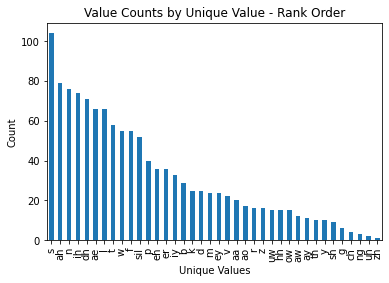

In [13]:
import matplotlib.pyplot as plt

# get the value counts and sort them in descending order
counts = phonemes_df['phoneme'].value_counts().sort_values(ascending=False)

# create a bar chart of the counts
fig, ax = plt.subplots()
counts.plot.bar(ax=ax)

# set the x-axis labels to the unique values
ax.set_xticklabels(counts.index)

# set the axis labels and title
ax.set_xlabel('Unique Values')
ax.set_ylabel('Count')
ax.set_title('Value Counts by Unique Value - Rank Order')

# display the plot
plt.show()

#### Analyse Original Predicted Phonemes

In [14]:
textgrid_fname = "./dataset/wsDmwoOrpR8/The False Appeal of Communism.TextGrid"
tg = TextGrid(textgrid_fname)

In [15]:
phones = tg["phones"]

In [ ]:
phones

In [17]:
xmax  = np.array([p.xmax for p in phones])
xmin  = np.array([p.xmin for p in phones])
ph_s  = [p.text for p in phones]
ph_df = pd.DataFrame({"xmax": xmax, "xmin": xmin, "text": ph_s})

In [18]:
ph_df["duration"] = xmax - xmin

In [19]:
ph_df

,xmax,xmin,text,duration
0,0.04000,0.00,,0.04000
1,0.09000,0.04,DH,0.05000
2,0.13000,0.09,IH1,0.04000
3,0.16000,0.13,S,0.03000
4,0.19000,0.16,IH0,0.03000
...,...,...,...,...
535,50.59000,50.44,S,0.15000
536,50.67000,50.59,T,0.08000
537,50.77000,50.67,EY1,0.10000
538,50.82000,50.77,T,0.05000


### Visualise Mel Spectrogram

In [20]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def plot_mel_spectrograms(pred, text):
    fig, ax = plt.subplots(1) # nrows=1, ncols=2)

    # ax[0].set_title(f"Mel Spectogram (Predicted)")
    pred = np.swapaxes(pred, 0, 1)
    cax = ax.imshow(pred, interpolation='nearest', cmap=cm.coolwarm, origin='lower')

    ax.set_title(text)
    
    return fig, ax

[]

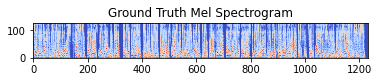

In [21]:
audio_feats = data["audio_feats"]
fig, ax = plot_mel_spectrograms(audio_feats, "Ground Truth Mel Spectrogram")
plt.plot()

## Model

#### LSTM

In [90]:
import torch
import torch.nn as nn
import torch.nn.functional as F
    
"""
class LipToVoiceModel(nn.Module):
    def __init__(self, input_dim, out_dim, num_layers, hidden_dim=32, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout)
        self.fc1 = nn.Linear(hidden_dim, out_dim)
    
    def forward(self, x: torch.tensor) -> torch.Tensor:
        x, _ = self.lstm(x)
        x = self.fc1(x)
        # x = F.softmax(x, dim=-1)
        return x
"""

class LipToVoiceModel(nn.Module):
    def __init__(self, input_dim, out_dim, num_layers, hidden_dim=32, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout,
            bidirectional=True)
        self.fc1 = nn.Linear(hidden_dim * 2, out_dim)
    
    def forward(self, x: torch.tensor) -> torch.Tensor:
        x, _ = self.lstm(x)
        x = self.fc1(x)
        # x = F.softmax(x, dim=-1)
        return x

### Transformer

In [91]:
import torch.nn as nn

from lib.transformer import TransformerEncoderLayer

class LipToVoiceTransformerModel(nn.Module):
    def __init__(self,
                 model_size,
                 dropout=0.2,
                 num_layers=6,
                 n_heads=8,
                 dim_feedforward=3072,
                 out_dim=80):
        super().__init__()

        encoder_layer = TransformerEncoderLayer(
            d_model=model_size,
            nhead=n_heads,
            relative_positional=True,
            relative_positional_distance=100,
            dim_feedforward=dim_feedforward,
            dropout=dropout)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers)
        self.w_out = nn.Linear(model_size, out_dim)
    
    def forward(self, x):
        x = x.transpose(0, 1)
        x = self.transformer(x)
        x = x.transpose(0, 1)

        # Final MLP
        x = self.w_out(x)

        return x

### Linear Projection (Just for Phoneme Classification)

In [126]:
import torch.nn as nn

class LipToPhoneModel(nn.Module):
    """Linear Projection from AV-HuBERT Embedding"""
    def __init__(self, ins, hidden, outs, dropout=0.5):
        super(LipToPhoneModel, self).__init__()

        print("Init start")

        self.fc1 = nn.Linear(ins, hidden)
        self.dropout = nn.Dropout(p=dropout)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden, outs)

        print("Init end")

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)

        return x

## Trainset and Testset

### All Possible Data

In [184]:
avhubert_feats = data["av_hubert"]
phonemes       = data["phonemes"]
audio_feats    = data["audio_feats"]
avhubert_feats.shape, phonemes.shape, audio_feats.shape

(torch.Size([1234, 768]), (1232,), (1232, 128))

In [185]:
data["phonemes"].shape

(1232,)

### Define Input, Output

In [186]:
device = "cuda"

In [187]:
x_s = avhubert_feats
# y_s = phonemes
y_s = audio_feats

### Randomise Order (K-Folds Acc Doubled)

In [188]:
print(x_s.shape[0], y_s.shape[0])
seq_len = min(x_s.shape[0], y_s.shape[0])
x_s = x_s[:seq_len, :]
y_s = y_s[:seq_len]
print(x_s.shape[0], y_s.shape[0])
assert x_s.shape[0] == y_s.shape[0]
random_idxs = np.random.permutation(x_s.shape[0])
x_s = x_s[random_idxs]
y_s = y_s[random_idxs]

1234 1232
1232 1232


In [189]:
x_s.shape, y_s.shape

(torch.Size([1232, 768]), (1232, 128))

In [190]:
x_s.dtype

torch.float32

In [191]:
import torch
# CUDA_LAUNCH_BLOCKING=1
x_s = torch.tensor(x_s, dtype=torch.float).to(device)
y_s = torch.tensor(y_s, dtype=torch.float).to("cuda")
# y_s = torch.tensor(y_s, dtype=torch.long).to(device)

/tmp/ipykernel_19433/2597474908.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_s = torch.tensor(x_s, dtype=torch.float).to(device)


In [192]:
# (seq_len, 98, 2) => (seq_len, 196)
x_s = x_s.view(x_s.shape[0], -1)

In [193]:
# Verify `x_s`` and `y_s` shape
x_s.shape, y_s.shape

(torch.Size([1232, 768]), torch.Size([1232, 128]))

In [194]:
dataset_ratio = 0.8
dataset_size  = min(x_s.shape[0], y_s.shape[0])
print(dataset_size)

1232


In [195]:
x_s = x_s[0:dataset_size, :]

In [196]:
train_x_s = x_s[0:int(dataset_size * dataset_ratio), :]
test_x_s  = x_s[int(dataset_size * dataset_ratio):,  :]

In [197]:
y_s = y_s[0:dataset_size]

In [198]:
train_y_s = y_s[0:int(dataset_size * dataset_ratio)]
test_y_s  = y_s[int(dataset_size * dataset_ratio):]

In [199]:
x_s.shape, y_s.shape, train_x_s.shape, train_y_s.shape, test_x_s.shape, test_y_s.shape

(torch.Size([1232, 768]),
 torch.Size([1232, 128]),
 torch.Size([985, 768]),
 torch.Size([985, 128]),
 torch.Size([247, 768]),
 torch.Size([247, 128]))

In [200]:
y_s.shape

torch.Size([1232, 128])

In [201]:
print(group_adjacent_duplicates(get_phone_list(y_s)))

RuntimeError: Boolean value of Tensor with more than one value is ambiguous

### BatchDim for Seq Models

In [202]:
# x_s = x_s.unsqueeze(0)
# y_s = y_s.unsqueeze(0)

In [203]:
print("FINAL SHAPES:")
x_s.shape, y_s.shape

FINAL SHAPES:


(torch.Size([1232, 768]), torch.Size([1232, 128]))

In [204]:
y_s.shape[-1]

128

## Train (Overfit) - Phoneme Classification (SKLearn)

In [118]:
x_s.shape, y_s.shape

(torch.Size([1232, 768]), torch.Size([1232]))

In [119]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

svm_x_s = x_s.cpu().detach()
svm_y_s = y_s.cpu().detach()

clf_s = ["svm", "random_forest", "neural_network"]
for clf_n in clf_s:
    if clf_n == "svm":
        clf = svm.SVC(kernel='linear')
    elif clf_n == "random_forest":
        clf = RandomForestClassifier(n_estimators=100)
    elif clf_n == "neural_network":
        clf = MLPClassifier(max_iter=1000)

    clf.fit(svm_x_s, svm_y_s)
    y_pred = clf.predict(svm_x_s)
    accuracy = accuracy_score(svm_y_s, y_pred)
    print("Classifier", clf_n, "Accuracy:", accuracy)

Classifier svm Accuracy: 1.0
Classifier random_forest Accuracy: 1.0
Classifier neural_network Accuracy: 1.0


In [120]:
svm_y_s[0:20], y_pred[0:20]

(tensor([16, 20, 11, 37, 13,  1, 18, 16, 22, 12, 20, 12, 16, 12, 12, 14, 18, 21,
         22, 22]),
 array([16, 20, 11, 37, 13,  1, 18, 16, 22, 12, 20, 12, 16, 12, 12, 14, 18,
        21, 22, 22]))

In [121]:
single_svm_x_s = svm_x_s[0]
single_svm_y_s = svm_y_s[0].item()
single_svm_x_s.shape, single_svm_y_s

(torch.Size([768]), 16)

In [122]:
single_svm_x_s = single_svm_x_s.unsqueeze(0)
single_svm_x_s.shape

torch.Size([1, 768])

In [123]:
single_y_pred = clf.predict(single_svm_x_s)
single_y_pred

array([16])

## Train (Generalise) - Phoneme Classification (SKLearn + K-Folds)

In [124]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

kernels = ["linear", "poly", "rbf", "sigmoid"]

svm_train_x_s = train_x_s.cpu().detach()
svm_train_y_s = train_y_s.cpu().detach()
svm_test_x_s = test_x_s.cpu().detach()
svm_test_y_s = test_y_s.cpu().detach()


def run_kfolds(model, x, y, splits):
    kf = KFold(n_splits=splits, shuffle=True)
    scores = cross_val_score(model, x, y, cv=kf, scoring="accuracy")
    return scores

clf_s = ["svm", "random_forest", "neural_network"]
for clf_n in clf_s:
    if clf_n == "svm":
        clf = svm.SVC(kernel='linear')
    if clf_n == "svm":
        for kernel in kernels:
            clf = svm.SVC(kernel=kernel)
            # clf.fit(svm_train_x_s, svm_train_y_s)
            # svm_y_pred = clf.predict(svm_test_x_s)
            # accuracy = accuracy_score(svm_test_y_s, svm_y_pred)
            scores = run_kfolds(clf, svm_x_s, svm_y_s, splits=5)
            print(
                "Classifier", clf_n,
                "Kernel:", kernel,
                "Scores:", scores,
                "Scores(mean):", scores.mean())
    elif clf_n == "random_forest":
        clf = RandomForestClassifier(n_estimators=100)
        #clf.fit(svm_train_x_s, svm_train_y_s)
        #svm_y_pred = clf.predict(svm_test_x_s)
        #accuracy = accuracy_score(svm_test_y_s, svm_y_pred)
        scores = run_kfolds(clf, svm_x_s, svm_y_s, splits=5)
        print(
            "Classifier", clf_n,
            "Kernel:", kernel,
            "Scores:", scores,
            "Scores(mean):", scores.mean())
    elif clf_n == "neural_network":
        clf = MLPClassifier(hidden_layer_sizes=(256), max_iter=100)
        # clf.fit(svm_train_x_s, svm_train_y_s)
        # svm_y_pred = clf.predict(svm_test_x_s)
        # accuracy = accuracy_score(svm_test_y_s, svm_y_pred)
        scores = run_kfolds(clf, svm_x_s, svm_y_s, splits=5)
        print(
            "Classifier", clf_n,
            "Kernel:", kernel,
            "Scores:", scores,
            "Scores(mean):", scores.mean())

Classifier svm Kernel: linear Scores: [0.59919028 0.63967611 0.6097561  0.57317073 0.63821138] Scores(mean): 0.6120009216286495
Classifier svm Kernel: poly Scores: [0.48178138 0.46558704 0.44308943 0.50813008 0.51219512] Scores(mean): 0.4821566110397947
Classifier svm Kernel: rbf Scores: [0.60323887 0.58704453 0.57723577 0.6097561  0.55284553] Scores(mean): 0.58602415983674
Classifier svm Kernel: sigmoid Scores: [0.56275304 0.57489879 0.55691057 0.45934959 0.56097561] Scores(mean): 0.5429775188440144
Classifier random_forest Kernel: sigmoid Scores: [0.53441296 0.57894737 0.56910569 0.56504065 0.5203252 ] Scores(mean): 0.5535663737204175


/home/joe/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/joe/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/joe/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/joe/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Classifier neural_network Kernel: sigmoid Scores: [0.62348178 0.64777328 0.64227642 0.60162602 0.67886179] Scores(mean): 0.6388038576742042


/home/joe/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


## Train (Overfit) - Mel Spectrogram (Neural Network)

device: cuda
x_s.device: cuda:0
Init start
Init end
y_s.shape[-1] original: 128
0 48.00372314453125 48.00372314453125 0.001
1000 0.4861772358417511 0.4861772358417511 0.001
2000 0.1441953033208847 0.1441953033208847 0.001
3000 0.05058863386511803 0.05058863386511803 0.001
4000 0.01829255186021328 0.01829255186021328 0.001
5000 0.007209299597889185 0.007209299597889185 0.001
6000 0.003273330396041274 0.003273330396041274 0.001
7000 0.0017448754515498877 0.0017448754515498877 0.001
8000 0.0017514731734991074 0.0017514731734991074 0.001
9000 0.0017625681357458234 0.0017625681357458234 0.001


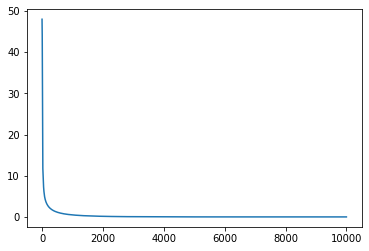

In [205]:
from torch.cuda.amp        import autocast, GradScaler
import matplotlib.pyplot   as plt
import torch.nn.functional as F
import torch

print("device:", device)
print("x_s.device:", x_s.device)

amp = True

model = LipToPhoneModel(
    x_s.shape[-1],
    512,
    y_s.shape[-1]).to(device)

print("y_s.shape[-1] original:", y_s.shape[-1])
epochs = 10000
lr = 1e-3

# optim = torch.optim.AdamW(params=model.parameters(), lr=lr)
optim = torch.optim.Adam(params=model.parameters(), lr=lr)

losses_s = []

scaler = GradScaler()
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, 'min')
# scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=2000, gamma=0.1)

pred_s = []

criteria = nn.MSELoss()

model.train()
for epoch_idx in range(epochs):
    with autocast(
        enabled=True,
        dtype=torch.bfloat16):

        pred = model(x_s)

        assert pred.shape[0] == y_s.shape[0]
        cur_pred = pred
        cur_y    = y_s
        #pred_phones = cur_pred.argmax(-1)
        #y_phones = cur_y
        # print("cur_pred.shape, cur_y.shape:", cur_pred.shape, cur_y.shape)
        loss = criteria(cur_pred, cur_y)
        
        if epoch_idx % 1000 == 0:
            # test
            model.eval()
            with torch.no_grad():
                test_pred = model(x_s)
                test_loss = criteria(test_pred, y_s)
                #test_pred_phones = test_pred.argmax(-1)
                #test_y_phones = y_s
                #correct_phones = (test_pred_phones == test_y_phones).sum().item()
                #acc = correct_phones / test_pred_phones.shape[-1]
            print(
                epoch_idx,
                loss.item(),
                test_loss.item(),
                optim.param_groups[0]['lr'],
                #test_pred_phones,
            )
                # f"{acc:.2%}",
                # "\n",
                # print_phone_list(test_pred_phones),
                # "\n",
                # print_phone_list(test_y_phones),
                # "\n")
            
            model.train()
        

        # print(pred, y)
        losses_s.append(loss.detach().item())

    #loss.backward()
    #optim.step()

    scaler.scale(loss).backward()
    scaler.step(optim)
    scaler.update()
    
    # scheduler.step(loss)


plt.plot(losses_s)

### Visualise Mel Spectrogram

In [206]:
from matplotlib import cm

def plot_mel_spectrogram(mel_spec, title):
    fig, ax = plt.subplots(1)

    ax.set_title(f"Mel Spectrogram \"{title}\"")
    pred = np.swapaxes(mel_spec, 0, 1)
    cax = ax.imshow(pred, interpolation='nearest', cmap=cm.coolwarm, origin='lower')

    return fig

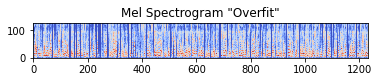

In [207]:
_ = plot_mel_spectrogram(cur_pred.cpu().detach().float(), "Overfit")

## Train (Generalise) - Mel Spectrogram (Neural Network)

device: cuda
x_s.device: cuda:0
Init start
Init end
y_s.shape[-1] original: 128
0 47.8541259765625 49.150665283203125 0.0001
1000 4.579741954803467 5.932426452636719 0.0001
2000 2.755094528198242 5.092698097229004 0.0001
3000 1.8687111139297485 5.011296272277832 0.0001
4000 1.2842094898223877 5.116762161254883 0.0001
5000 0.8711457848548889 5.326091766357422 0.0001
6000 0.574129045009613 5.562981128692627 0.0001
7000 0.3697463274002075 5.780623435974121 0.0001
8000 0.2354949414730072 5.990952491760254 0.0001
9000 0.14886336028575897 6.205268383026123 0.0001


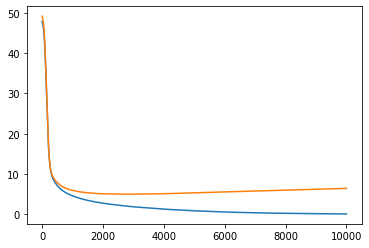

In [208]:
from torch.cuda.amp        import autocast, GradScaler
import matplotlib.pyplot   as plt
import torch.nn.functional as F
import torch

print("device:", device)
print("x_s.device:", x_s.device)

amp = True

model = LipToPhoneModel(
    train_x_s.shape[-1],
    256,
    train_y_s.shape[-1]).to(device)

print("y_s.shape[-1] original:", y_s.shape[-1])
epochs = 10_000
lr = 1e-4

# optim = torch.optim.AdamW(params=model.parameters(), lr=lr)
optim = torch.optim.Adam(params=model.parameters(), lr=lr)

losses_s = []
vlosses_s = []
scaler = GradScaler()
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, 'min')
# scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=2000, gamma=0.1)

pred_s = []

criteria = nn.MSELoss()

model.train()
for epoch_idx in range(epochs):
    with autocast(
        enabled=True,
        dtype=torch.bfloat16):

        pred = model(train_x_s)

        # print("pred.shape[0], train_y_s.shape[0]:", pred.shape, train_y_s.shape)
        assert pred.shape[0] == train_y_s.shape[0]
        cur_pred = pred
        cur_y    = train_y_s
        #pred_phones = cur_pred.argmax(-1)
        #y_phones = cur_y
        # print("cur_pred.shape, cur_y.shape:", cur_pred.shape, cur_y.shape)
        loss = criteria(cur_pred, cur_y)
        
        
        # test
        model.eval()
        with torch.no_grad():
            test_pred = model(test_x_s)
            test_loss = criteria(test_pred, test_y_s)
            vlosses_s.append(test_loss.detach().item())
            #test_pred_phones = test_pred.argmax(-1)
            #test_y_phones = y_s
            #correct_phones = (test_pred_phones == test_y_phones).sum().item()
            #acc = correct_phones / test_pred_phones.shape[-1]
        if epoch_idx % 1000 == 0:
            print(
                epoch_idx,
                loss.item(),
                test_loss.item(),
                optim.param_groups[0]['lr'],
                #test_pred_phones,
            )
                # f"{acc:.2%}",
                # "\n",
                # print_phone_list(test_pred_phones),
                # "\n",
                # print_phone_list(test_y_phones),
                # "\n")
            
        model.train()
        

        # print(pred, y)
        losses_s.append(loss.detach().item())

    #loss.backward()
    #optim.step()

    scaler.scale(loss).backward()
    scaler.step(optim)
    scaler.update()
    
    # scheduler.step(loss)

plt.plot(losses_s)
plt.plot(vlosses_s)

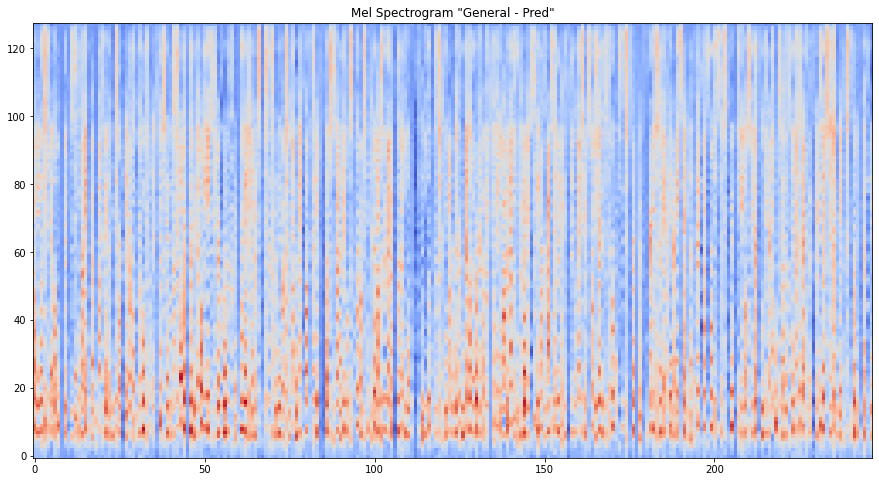

In [212]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (16,8)
_ = plot_mel_spectrogram(test_pred.cpu().detach().float(), "General - Pred")

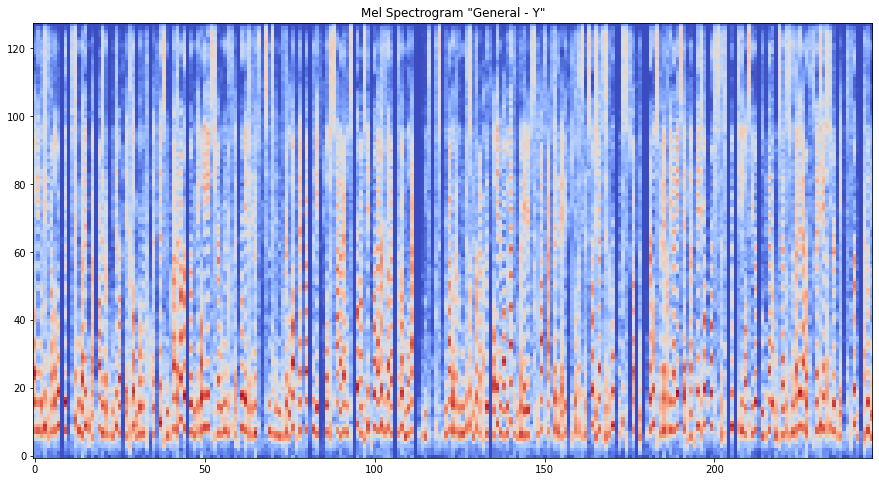

In [213]:
_ = plot_mel_spectrogram(test_y_s.cpu().detach().float(), "General - Y")

## Train (Overfit) - Phone (Neural Network)

In [214]:
def get_phone_list(phones):
    d = [dataset.phoneme_dict[int(ph_id)]
        if ph_id < len(dataset.phoneme_dict)
        else -1
        for ph_id in phones]
    return d

In [215]:
def print_phone_list(phones):
    d = [dataset.phoneme_dict[int(ph_id)]
        if ph_id < len(dataset.phoneme_dict)
        else -1
        for ph_id in phones]
    print(d)

device: cuda
x_s.device: cuda:0
Init start
Init end
y_s.shape[-1] original: 1232
['d', 'm', 'p', 'aa', 'ng', 'aw', 'l', 'ng', 'l', 'l', 'l', 'ng', 'aa', 'l', 'l', 't', 'aw', 'ow', 'ow', 'aw', 'r', 'aa', 'sil', 'aw', 'v', 'aw', 'k', 'aa', 'sil', 'aw', 'l', 'ow', 'd', 'l', 'aa', 'r', 'aw', 'ow', 'l', 'd', 'z', 'r', 'd', 'sil', 'sil', 'r', 'z', 'aa', 'aa', 'ow', 'oy', 'm', 'ng', 'ng', 'aw', 'z', 'm', 'aw', 'm', 'z', 'sil', 'm', 'ae', 'l', 'sil', 'sil', 'ay', 'm', 'l', 'aw', 'sil', 'k', 'aa', 'l', 'aa', 'l', 'jh', 'r', 'er', 'oy', 'l', 'm', 'ow', 'ow', 'r', 'ay', 'k', 'sil', 'l', 'aa', 'l', 'n', 'z', 'l', 'b', 'sil', 'aa', 'oy', 'aa', 'l', 'z', 'sil', 'm', 'l', 'ng', 'z', 'v', 'r', 'z', 'r', 'sil', 'sil', 'd', 'ng', 'aa', 'l', 'l', 'sil', 'm', 'b', 'aa', 'm', 'l', 'd', 'sil', 'aa', 'ng', 'l', 'ng', 'k', 'aa', 'm', 'z', 'm', 'ng', 'ow', 'l', 'r', 'sil', 'n', 'sil', 'v', 'sil', 'jh', 'l', 'ow', 'ow', 'sil', 'z', 'sil', 'aw', 'ng', 'l', 'd', 'm', 'k', 'm', 'sil', 'l', 'ow', 'z', 'oy', 'l', 'o

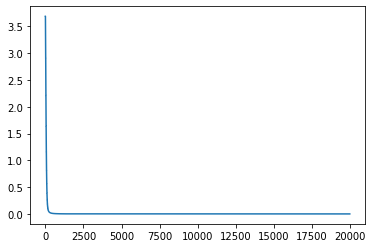

In [130]:
from torch.cuda.amp        import autocast, GradScaler
import matplotlib.pyplot   as plt
import torch.nn.functional as F
import torch

print("device:", device)
print("x_s.device:", x_s.device)

amp = True

model = LipToPhoneModel(
    x_s.shape[-1],
    512,
    len(dataset.phoneme_dict)).to(device)

print("y_s.shape[-1] original:", y_s.shape[-1])
epochs = 10000
lr = 1e-3

# optim = torch.optim.AdamW(params=model.parameters(), lr=lr)
optim = torch.optim.Adam(params=model.parameters(), lr=lr)

losses_s = []

scaler = GradScaler()
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, 'min')
# scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=2000, gamma=0.1)

pred_s = []

criteria = nn.CrossEntropyLoss()

model.train()
for epoch_idx in range(epochs):
    with autocast(
        enabled=True,
        dtype=torch.bfloat16):

        # print("pre model x_s.shape:", x_s.shape)
        pred = model(x_s)
        pred = F.log_softmax(pred, -1)
        pred_phones = pred.argmax(-1)
        y_phones = y_s
        # pred_code = dataset.decode(pred[0])

        assert pred.shape[0] == y_s.shape[0]
        # loss_iter = 1 # pred.shape[0]
        #losses = []
        #correct_phones = 0
        #total_len = 0

        #print("loss_iter:", loss_iter)
        #print("y_s.shape:", y_s.shape)
        # for iter in range(loss_iter):
            #print("pred.shape, y_s.shape:", pred.shape, y_s.shape)
        cur_pred = pred
        cur_y    = y_s
        pred_phones = cur_pred.argmax(-1)
        y_phones = cur_y
        #print("cur_pred.shape, cur_y.shape:", cur_pred.shape, cur_y.shape)
        #print("cur_pred.dtype, cur_y.dtype:", cur_pred.dtype, cur_y.dtype)
        loss = criteria(cur_pred, cur_y)
        #losses.append(loss)
        losses_s.append(loss.item())
        correct_phones = (pred_phones == y_phones).sum().item()
        # print("pred_phones.shape, y_phones.shape:", pred_phones.shape, y_phones.shape)
        # print("correct_phones:", correct_phones, y_phones, y_phones.shape)
        #total_len += y_phones.size(0)
        #loss = sum(losses) / loss_iter

        # print(
        #     "pred.shape, y_s.shape:",
        #     pred.shape,
        #     y_s.shape,
        #     pred_phones,
        #     y_s)
        
            # print_phone_list(pred_phones),
            # print_phone_list(y_s))
        

        #loss = criteria(pred, y_s)
        # loss = F.mse_loss(pred, y_s)
        
        if epoch_idx % 1000 == 0:
            # test
            model.eval()
            with torch.no_grad():
                test_pred = model(x_s)
                test_loss = criteria(test_pred, y_s)
                test_pred_phones = test_pred.argmax(-1)
                test_y_phones = y_s
                correct_phones = (test_pred_phones == test_y_phones).sum().item()
                #print("test_pred.shape, test_pred_phones.shape:", test_pred.shape, test_pred_phones.shape)
                #print("test_pred_phones, test_y_phones", test_pred_phones, test_y_phones)
                acc = correct_phones / test_pred_phones.shape[-1]
            print(
                epoch_idx,
                loss.item(),
                test_loss.item(),
                optim.param_groups[0]['lr'],
                #test_pred_phones,
                f"{acc:.2%}",
                "\n",
                print_phone_list(test_pred_phones),
                "\n",
                print_phone_list(test_y_phones),
                "\n")
            
            model.train()
        

        # print(pred, y)
        losses_s.append(loss.detach().item())

    #loss.backward()
    #optim.step()

    scaler.scale(loss).backward()
    scaler.step(optim)
    scaler.update()
    
    # scheduler.step(loss)


plt.plot(losses_s)

## Train (Generalise) - Phone (Neural Network)

device: cuda
train_x_s.device: cuda:0
Init start
Init end
y_s.shape[-1] original: 985
['jh', 'sh', 'ao', 'sh', 'ao', 'eh', 'ey', 'jh', 'th', 'sh', 'n', 'n', 'eh', 'jh', 'n', 'n', 'n', 'jh', 'n', 'jh', 'jh', 'sh', 'jh', 'n', 'jh', 'jh', 'th', 'jh', 'sh', 'jh', 'sh', 'n', 'y', 'jh', 'th', 'jh', 'n', 'eh', 'sh', 'sh', 'g', 'jh', 'sh', 'ao', 'jh', 'th', 'sh', 'n', 'jh', 'th', 'n', 'th', 'n', 'ao', 'jh', 'ao', 'n', 'th', 'sh', 'n', 'sh', 'y', 'eh', 'n', 'jh', 'jh', 'th', 'y', 'n', 'jh', 'n', 'n', 'th', 'sh', 'ao', 'z', 'z', 'jh', 'jh', 'jh', 'n', 'jh', 'sh', 'eh', 'n', 'eh', 'jh', 'eh', 'eh', 'jh', 'ao', 'n', 'sh', 'jh', 'sh', 'eh', 'eh', 'eh', 'z', 'eh', 'sh', 'ao', 'jh', 'sh', 'sh', 'n', 'n', 'ao', 'n', 'n', 'jh', 'jh', 'z', 'jh', 'ao', 'jh', 'jh', 'jh', 'n', 'n', 'jh', 'eh', 'jh', 'sh', 'n', 'ao', 'n', 'n', 'jh', 'jh', 'sh', 'n', 'n', 'n', 'jh', 'n', 'z', 'th', 'z', 'eh', 'n', 'n', 'jh', 'n', 'sh', 'jh', 'n', 'sh', 'n', 'sh', 'ao', 'jh', 'sh', 'sh', 'n', 'jh', 'ao', 'n', 'n', 'n', 'jh', 

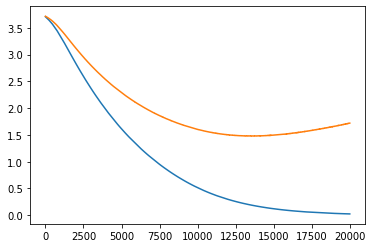

Text(0.5, 1.0, 'Peak Acc: 100.00%, Peak VAcc: 62.75%')

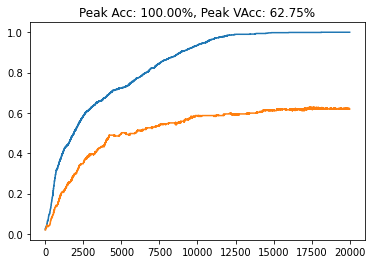

In [147]:
from torch.cuda.amp        import autocast, GradScaler
import matplotlib.pyplot   as plt
import torch.nn.functional as F
import torch

print("device:", device)
print("train_x_s.device:", train_x_s.device)

amp = True

model = LipToPhoneModel(
    train_x_s.shape[-1],
    64,
    len(dataset.phoneme_dict),
    dropout=0.5).to(device)

print("y_s.shape[-1] original:", train_y_s.shape[-1])
epochs = 20000
lr = 1e-5

# optim = torch.optim.AdamW(params=model.parameters(), lr=lr)
optim = torch.optim.AdamW(params=model.parameters(), lr=lr)

losses_s = []
vlosses_s = []

scaler = GradScaler()
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, 'min')
scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=epochs, gamma=0.1)

pred_s = []

acc_s = []
vacc_s = []
criteria = nn.CrossEntropyLoss()

model.train()
for epoch_idx in range(epochs):
    with autocast(
        enabled=True,
        dtype=torch.bfloat16):

        # print("pre model x_s.shape:", x_s.shape)
        pred = model(train_x_s)
        pred = F.log_softmax(pred, -1)
        pred_phones = pred.argmax(-1)
        y_phones = train_y_s
        # pred_code = dataset.decode(pred[0])

        assert pred.shape[0] == train_y_s.shape[0]
        # loss_iter = 1 # pred.shape[0]
        #losses = []
        #correct_phones = 0
        #total_len = 0

        #print("loss_iter:", loss_iter)
        #print("y_s.shape:", y_s.shape)
        # for iter in range(loss_iter):
            #print("pred.shape, y_s.shape:", pred.shape, y_s.shape)
        cur_pred = pred
        cur_y    = train_y_s
        pred_phones = cur_pred.argmax(-1)
        y_phones = cur_y
        #print("cur_pred.shape, cur_y.shape:", cur_pred.shape, cur_y.shape)
        #print("cur_pred.dtype, cur_y.dtype:", cur_pred.dtype, cur_y.dtype)
        loss = criteria(cur_pred, cur_y)
        #losses.append(loss)
        losses_s.append(loss.item())
        correct_phones = (pred_phones == y_phones).sum().item()
        acc = correct_phones / pred_phones.shape[-1]
        acc_s.append(acc)
        # print("pred_phones.shape, y_phones.shape:", pred_phones.shape, y_phones.shape)
        # print("correct_phones:", correct_phones, y_phones, y_phones.shape)
        #total_len += y_phones.size(0)
        #loss = sum(losses) / loss_iter

        # print(
        #     "pred.shape, y_s.shape:",
        #     pred.shape,
        #     y_s.shape,
        #     pred_phones,
        #     y_s)
        
            # print_phone_list(pred_phones),
            # print_phone_list(y_s))
        

        #loss = criteria(pred, y_s)
        # loss = F.mse_loss(pred, y_s)
        
        
        # test
        model.eval()
        with torch.no_grad():
            test_pred = model(test_x_s)
            test_loss = criteria(test_pred, test_y_s)
            test_pred_phones = test_pred.argmax(-1)
            test_y_phones = test_y_s
            correct_phones = (test_pred_phones == test_y_phones).sum().item()
            #print("test_pred.shape, test_pred_phones.shape:", test_pred.shape, test_pred_phones.shape)
            #print("test_pred_phones, test_y_phones", test_pred_phones, test_y_phones)
            vacc = correct_phones / test_pred_phones.shape[-1]
            vacc_s.append(vacc)
            vlosses_s.append(test_loss.detach().item())

        if epoch_idx % 1000 == 0:
            print(
                epoch_idx,
                loss.item(),
                test_loss.item(),
                optim.param_groups[0]['lr'],
                #test_pred_phones,
                f"{vacc:.2%}",
                "\n",
                print_phone_list(test_pred_phones),
                "\n",
                print_phone_list(test_y_phones),
                "\n")
            
        model.train()
        
        # print(pred, y)
        # losses_s.append(loss.detach().item())

    #loss.backward()
    #optim.step()

    scaler.scale(loss).backward()
    scaler.step(optim)
    scaler.update()
    
    # scheduler.step(test_loss)
    scheduler.step()

plt.plot(losses_s)
plt.plot(vlosses_s)
plt.show()
plt.plot(acc_s)
plt.plot(vacc_s)
plt.title(f"Peak Acc: {max(acc_s):.2%}, Peak VAcc: {max(vacc_s):.2%}")

### Test Set Phoneme Distribution

In [134]:
print_phone_list(test_y_s)
#test_y_ph_lst = get_phone_list(test_y_phones.cpu())
## test_y_ph_lst = group_adjacent_duplicates(test_y_ph_lst)
#print(test_y_ph_lst)

['d', 'dh', 'dh', 'ah', 'dh', 'w', 'sil', 's', 'n', 's', 'ey', 't', 'ao', 's', 'l', 'uw', 'v', 'w', 'p', 'd', 'ah', 'ah', 'dh', 'l', 'uw', 's', 's', 'iy', 'ae', 'ih', 'eh', 'uw', 'r', 'sil', 'ng', 'sil', 'r', 's', 'k', 'dh', 'f', 'ae', 'iy', 'r', 'p', 'n', 'dh', 'hh', 'ih', 'ih', 'ah', 's', 'ah', 'dh', 't', 'y', 'b', 'n', 'k', 'p', 'dh', 'g', 'f', 'sil', 's', 'ah', 's', 'n', 'm', 'ow', 'k', 's', 'iy', 'ae', 'hh', 'r', 'ih', 'ih', 'l', 'ow', 'k', 't', 'w', 'ih', 'ey', 'm', 'ch', 'dh', 'ah', 'n', 'er', 'n', 't', 'n', 'eh', 'd', 's', 'y', 'ah', 'er', 'w', 's', 'l', 'm', 'n', 'ah', 'k', 's', 'sil', 'ay', 't', 'er', 'w', 's', 't', 'eh', 'k', 'n', 'b', 'ah', 'ah', 'd', 'w', 'ae', 'dh', 'w', 'p', 'k', 'dh', 'ih', 'ah', 'aa', 'ae', 'm', 's', 'dh', 'ah', 'ae', 'ah', 'b', 'ng', 'v', 'd', 'hh', 'n', 'dh', 'w', 'l', 'n', 'eh', 'ao', 'l', 'k', 'ae', 'ow', 's', 'd', 'sil', 'aa', 'l', 'uw', 'f', 'b', 'm', 'ae', 'ah', 'w', 's', 'eh', 'ih', 'ih', 'aa', 'ah', 'eh', 's', 'hh', 'l', 'sil', 'dh', 'ah', 't'

(247, 1)


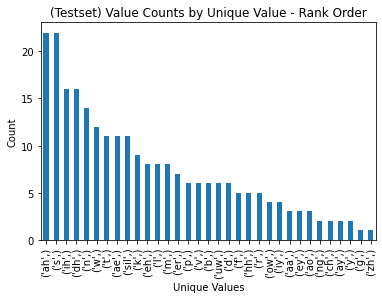

In [135]:
import matplotlib.pyplot as plt

test_y_df = pd.DataFrame(columns=["phoneme"], data=[dataset.phoneme_dict[d]
                                                    for d in test_y_phones.cpu()])

# get the value counts and sort them in descending order
counts = test_y_df.value_counts().sort_values(ascending=False)

# create a bar chart of the counts
fig, ax = plt.subplots()
counts.plot.bar(ax=ax)

# set the x-axis labels to the unique values
ax.set_xticklabels(counts.index)

# set the axis labels and title
ax.set_xlabel('Unique Values')
ax.set_ylabel('Count')
ax.set_title('(Testset) Value Counts by Unique Value - Rank Order')

# display the plot
print(test_y_df.shape)
plt.show()

### Phoneme Prediction Confusion Matrix

In [136]:
cm_pred = test_pred_phones.cpu()

In [137]:
cm_y = test_y_phones.cpu()

In [138]:
cm_y

tensor([37, 21, 21, 13, 21, 38,  0,  1, 22,  1, 15, 14, 29,  1, 36, 23, 24, 38,
        20, 37, 13, 13, 21, 36, 23,  1,  1,  5, 12,  2, 18, 23, 35,  0, 25,  0,
        35,  1, 31, 21, 16, 12,  5, 35, 20, 22, 21,  6,  2,  2, 13,  1, 13, 21,
        14, 10, 39, 22, 31, 20, 21,  9, 16,  0,  1, 13,  1, 22, 11, 30, 31,  1,
         5, 12,  6, 35,  2,  2, 36, 30, 31, 14, 38,  2, 15, 11, 32, 21, 13, 22,
        27, 22, 14, 22, 18, 37,  1, 10, 13, 27, 38,  1, 36, 11, 22, 13, 31,  1,
         0,  4, 14, 27, 38,  1, 14, 18, 31, 22, 39, 13, 13, 37, 38, 12, 21, 38,
        20, 31, 21,  2, 13, 19, 12, 11,  1, 21, 13, 12, 13, 39, 25, 24, 37,  6,
        22, 21, 38, 36, 22, 18, 29, 36, 31, 12, 30,  1, 37,  0, 19, 36, 23, 16,
        39, 11, 12, 13, 38,  1, 18,  2,  2, 19, 13, 18,  1,  6, 36,  0, 21, 13,
        14, 13,  2, 27, 16, 24, 12, 21,  2, 27, 38, 23, 21, 11, 18, 22,  0, 13,
        32, 24,  2, 35, 38, 14, 14, 38,  0, 39,  0, 20, 22, 27, 31, 15, 18, 13,
        24, 13, 22, 30, 20,  1, 14, 23, 

In [139]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(cm_y, cm_pred)

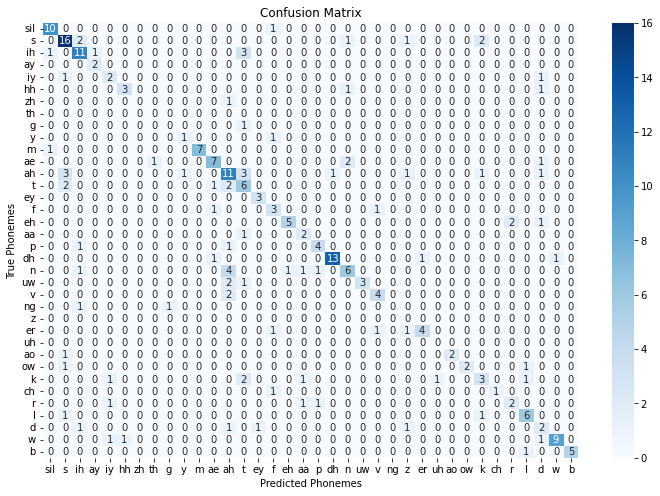

In [140]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# labels = np.unique(cm_y)
# phone_dict_idxs = list(range(len(dataset.phoneme_dict)))
labels = np.unique(torch.concat((cm_y, cm_pred), dim=0))

labels = [dataset.phoneme_dict[ph] for ph in labels]

# Plot confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=labels, yticklabels=labels)

# Set labels and title
plt.xlabel('Predicted Phonemes')
plt.ylabel('True Phonemes')
plt.title('Confusion Matrix')

# Show the plot
plt.show()

In [141]:
cm

array([[10,  0,  0, ...,  0,  0,  0],
       [ 0, 16,  2, ...,  0,  0,  0],
       [ 1,  0, 11, ...,  0,  0,  0],
       ...,
       [ 0,  0,  1, ...,  2,  0,  0],
       [ 0,  0,  0, ...,  1,  9,  0],
       [ 0,  0,  0, ...,  0,  0,  5]])

In [142]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Extracting true negatives, false positives, false negatives, true positives
# tn, fp, fn, tp = cm[0, 0], cm[0, 1], cm[1, 0], cm[1, 1]

# Compute evaluation metrics
accuracy   = accuracy_score(cm_y, cm_pred)
precision  = precision_score(cm_y, cm_pred, average="micro")
recall     = recall_score(cm_y, cm_pred, average="micro")
f1         = f1_score(cm_y, cm_pred, average="micro")

# Print confusion matrix and evaluation metrics
print("Confusion Matrix:")
print(cm)
# print("True Negatives:", tn)
# print("False Positives:", fp)
# print("False Negatives:", fn)
# print("True Positives:", tp)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Confusion Matrix:
[[10  0  0 ...  0  0  0]
 [ 0 16  2 ...  0  0  0]
 [ 1  0 11 ...  0  0  0]
 ...
 [ 0  0  1 ...  2  0  0]
 [ 0  0  0 ...  1  9  0]
 [ 0  0  0 ...  0  0  5]]
Accuracy: 0.6275303643724697
Precision: 0.6275303643724697
Recall: 0.6275303643724697
F1 Score: 0.6275303643724697
